# Quickstart: How to think in JAX

<!--* freshness: { reviewed: '2024-04-08' } *-->

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jax-ml/jax/blob/main/docs/notebooks/thinking_in_jax.ipynb) [![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/jax-ml/jax/blob/main/docs/notebooks/thinking_in_jax.ipynb)

**JAX is a library for array-oriented numerical computation (*à la* [NumPy](https://numpy.org/)), with automatic differentiation and JIT compilation to enable high-performance machine learning research**.

This document provides a quick overview of essential JAX features, so you can get started with JAX:

* JAX provides a unified NumPy-like interface to computations that run on CPU, GPU, or TPU, in local or distributed settings.
* JAX features built-in Just-In-Time (JIT) compilation via [Open XLA](https://github.com/openxla), an open-source machine learning compiler ecosystem.
* JAX functions support efficient evaluation of gradients via its automatic differentiation transformations.
* JAX functions can be automatically vectorized to efficiently map them over arrays representing batches of inputs.

## Installation

JAX can be installed for CPU on Linux, Windows, and macOS directly from the [Python Package Index](https://pypi.org/project/jax/):

```
pip install jax
```
or, for NVIDIA GPU:

```
pip install -U "jax[cuda12]"
```
For more detailed platform-specific installation information, check out [Installation](https://docs.jax.dev/en/latest/installation.html).

## JAX vs. NumPy

**Key concepts:**

- JAX provides a NumPy-inspired interface for convenience.
- Through [duck-typing](https://en.wikipedia.org/wiki/Duck_typing), JAX arrays can often be used as drop-in replacements of NumPy arrays.
- Unlike NumPy arrays, JAX arrays are always immutable.

NumPy provides a well-known, powerful API for working with numerical data. For convenience, JAX provides [`jax.numpy`](https://docs.jax.dev/en/latest/jax.numpy.html) which closely mirrors the NumPy API and provides easy entry into JAX. Almost anything that can be done with `numpy` can be done with `jax.numpy`, which is typically imported under the `jnp` alias:

In [1]:
import jax.numpy as jnp

With this import, you can immediately use JAX in a similar manner to typical NumPy programs, including using NumPy-style array creation functions, Python functions and operators, and array attributes and methods:

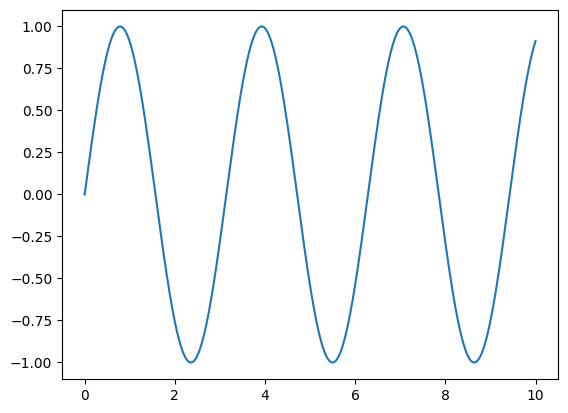

In [ ]:
import matplotlib.pyplot as plt

x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp);

The code blocks are identical to what you would expect with NumPy, aside from replacing `np` with `jnp`, and the results are the same. As we can see, JAX arrays can often be used directly in place of NumPy arrays for things like plotting.

The arrays themselves are implemented as different Python types:

In [4]:
import numpy as np
import jax.numpy as jnp

x_np = np.linspace(0, 10, 1000)
x_jnp = jnp.linspace(0, 10, 1000)

In [5]:
type(x_np)

numpy.ndarray

In [6]:
type(x_jnp)

jaxlib._jax.ArrayImpl

Python's duck-typing allows JAX arrays and NumPy arrays to be used interchangeably in many places. However, there is one important difference between JAX and NumPy arrays: JAX arrays are immutable, meaning that once created their contents cannot be changed.

Here is an example of mutating an array in NumPy:

In [7]:
# NumPy: mutable arrays
x = np.arange(10)
x[0] = 10
print(x)

[10  1  2  3  4  5  6  7  8  9]


The equivalent in JAX results in an error, as JAX arrays are immutable:

In [8]:
%xmode minimal

Exception reporting mode: Minimal


In [9]:
# JAX: immutable arrays
x = jnp.arange(10)
x[0] = 10

TypeError: JAX arrays are immutable and do not support in-place item assignment. Instead of x[idx] = y, use x = x.at[idx].set(y) or another .at[] method: https://docs.jax.dev/en/latest/_autosummary/jax.numpy.ndarray.at.html

For updating individual elements, JAX provides an [indexed update syntax](https://docs.jax.dev/en/latest/_autosummary/jax.numpy.ndarray.at.html#jax-numpy-ndarray-at) that returns an updated copy:

In [10]:
y = x.at[0].set(10)
print(x)
print(y)

[0 1 2 3 4 5 6 7 8 9]
[10  1  2  3  4  5  6  7  8  9]


You'll find a few differences between JAX arrays and NumPy arrays once you begin digging in. See also:

- [Key concepts](https://docs.jax.dev/en/latest/key-concepts.html#jax-arrays-jax-array) for an introduction to the key concepts of JAX, such as transformations, tracing, jaxprs and pytrees.
- [🔪 JAX - The Sharp Bits 🔪](https://docs.jax.dev/en/latest/notebooks/Common_Gotchas_in_JAX.html) for common gotchas when using JAX.

## JAX arrays (`jax.Array`)

**Key concepts:**
- Create arrays using JAX API functions.
- JAX array objects have a `devices` attribute that indicates where the array is stored.
- JAX arrays can be *sharded* across multiple devices for parallel computation.

The default array implementation in JAX is [`jax.Array`](https://docs.jax.dev/en/latest/_autosummary/jax.Array.html#jax.Array). In many ways it is similar to
the [`numpy.ndarray`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html#numpy.ndarray) type that you may be familiar with from the NumPy package, but it
has some important differences.

### Array creation

We typically don't call the `jax.Array` constructor directly, but rather create arrays via JAX API functions.
For example, [`jax.numpy`](https://docs.jax.dev/en/latest/jax.numpy.html#module-jax.numpy) provides familiar NumPy-style array construction functionality
such as `jax.numpy.zeros`, `jax.numpy.linspace`, `jax.numpy.arange`, etc.

In [ ]:
import jax
import jax.numpy as jnp

x = jnp.arange(5)
isinstance(x, jax.Array)

If you use Python type annotations in your code, `jax.Array` is the appropriate
annotation for jax array objects (see [`jax.typing`](https://docs.jax.dev/en/latest/jax.typing.html#module-jax.typing) for more discussion).

### Array devices and sharding

JAX Array objects have a `devices` method that lets you inspect where the contents of the array are stored. In the simplest cases, this will be a single CPU device:

In [ ]:
x.devices()

In general, an array may be [*sharded*](https://docs.jax.dev/en/latest/notebooks/Distributed_arrays_and_automatic_parallelization.html) across multiple devices, in a manner that can be inspected via the `sharding` attribute:

In [ ]:
x.sharding

Here the array is on a single device, but in general a JAX array can be
sharded across multiple devices, or even multiple hosts.
To read more about sharded arrays and parallel computation, refer to [Introduction to parallel programming](https://docs.jax.dev/en/latest/sharded-computation.html).

## Just-in-time compilation with `jax.jit`

**Key concepts:**

- By default JAX executes operations one at a time, in sequence.
- Using a just-in-time (JIT) compilation decorator, sequences of operations can be optimized together and run at once.
- Not all JAX code can be JIT compiled, as it requires array shapes to be static & known at compile time.

JAX runs transparently on the GPU or TPU (falling back to CPU if you don't have one), with all JAX operations being expressed in terms of XLA. If we have a sequence of operations, we can use the [`jax.jit`](https://docs.jax.dev/en/latest/_autosummary/jax.jit.html) function to compile this sequence of operations together using the XLA compiler.

For example, consider this function that normalizes the rows of a 2D matrix, expressed in terms of `jax.numpy` operations:

In [14]:
import jax.numpy as jnp

def norm(X):
  X = X - X.mean(0)
  return X / X.std(0)

A just-in-time compiled version of the function can be created using the `jax.jit` transform:

In [ ]:
from jax import jit
norm_compiled = jit(norm)

This function returns the same results as the original, up to standard floating-point accuracy:

In [ ]:
np.random.seed(1701)
X = jnp.array(np.random.rand(10000, 10))
np.allclose(norm(X), norm_compiled(X), atol=1E-6)

True

But due to the compilation (which includes fusing of operations, avoidance of allocating temporary arrays, and a host of other tricks), execution times can be orders of magnitude faster in the JIT-compiled case. We can use IPython's `%timeit` to quickly benchmark our function, using `block_until_ready()` to account for JAX's [asynchronous dispatch](https://docs.jax.dev/en/latest/async_dispatch.html):

In [ ]:
%timeit norm(X).block_until_ready()
%timeit norm_compiled(X).block_until_ready()

815 µs ± 224 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
656 µs ± 10.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


That said, `jax.jit` does have limitations: in particular, it requires all arrays to have static shapes. That means that some JAX operations are incompatible with JIT compilation.

For example, this operation can be executed in op-by-op mode:

In [ ]:
def get_negatives(x):
  return x[x < 0]

x = jnp.array(np.random.randn(10))
get_negatives(x)

Array([-0.10570311, -0.59403396, -0.8680282 , -0.23489487], dtype=float32)

But it returns an error if you attempt to execute it in jit mode:

In [ ]:
jit(get_negatives)(x)

NonConcreteBooleanIndexError: ignored

This is because the function generates an array whose shape is not known at compile time: the size of the output depends on the values of the input array, and so it is not compatible with JIT.

For more on JIT compilation in JAX, check out {ref}`jit-compilation`.

### JIT mechanics: tracing and static variables

**Key concepts:**

- JIT and other JAX transforms work by *tracing* a function to determine its effect on inputs of a specific shape and type.

- Variables that you don't want to be traced can be marked as *static*

To use `jax.jit` effectively, it is useful to understand how it works. Let's put a few `print()` statements within a JIT-compiled function and then call the function:

In [21]:
@jit
def f(x, y):
  print("Running f():")
  print(f"  x = {x}")
  print(f"  y = {y}")
  result = jnp.dot(x + 1, y + 1)
  print(f"  result = {result}")
  return result

x = np.random.randn(3, 4)
y = np.random.randn(4)
f(x, y)

Running f():
  x = Traced<ShapedArray(float32[3,4])>with<DynamicJaxprTrace(level=1/0)>
  y = Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=1/0)>
  result = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>


Array([0.25773212, 5.3623195 , 5.403243  ], dtype=float32)

Notice that the print statements execute, but rather than printing the data we passed to the function, though, it prints *tracer* objects that stand-in for them.

These tracer objects are what `jax.jit` uses to extract the sequence of operations specified by the function. Basic tracers are stand-ins that encode the **shape** and **dtype** of the arrays, but are agnostic to the values. This recorded sequence of computations can then be efficiently applied within XLA to new inputs with the same shape and dtype, without having to re-execute the Python code.

When we call the compiled function again on matching inputs, no re-compilation is required and nothing is printed because the result is computed in compiled XLA rather than in Python:

In [22]:
x2 = np.random.randn(3, 4)
y2 = np.random.randn(4)
f(x2, y2)

Array([1.4344584, 4.3004413, 7.9897013], dtype=float32)

The extracted sequence of operations is encoded in a JAX expression, or [*jaxpr*](https://docs.jax.dev/en/latest/key-concepts.html#jaxprs) for short. You can view the jaxpr using the `jax.make_jaxpr` transformation:

In [23]:
from jax import make_jaxpr

def f(x, y):
  return jnp.dot(x + 1, y + 1)

make_jaxpr(f)(x, y)

{ lambda ; a:f32[3,4] b:f32[4]. let
    c:f32[3,4] = add a 1.0
    d:f32[4] = add b 1.0
    e:f32[3] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c d
  in (e,) }

Note one consequence of this: because JIT compilation is done *without* information on the content of the array, control flow statements in the function cannot depend on traced values. For example, this fails:

In [24]:
@jit
def f(x, neg):
  return -x if neg else x

f(1, True)

TracerBoolConversionError: ignored

If there are variables that you would not like to be traced, they can be marked as static for the purposes of JIT compilation:

In [25]:
from functools import partial

@partial(jit, static_argnums=(1,))
def f(x, neg):
  return -x if neg else x

f(1, True)

Array(-1, dtype=int32, weak_type=True)

Note that calling a JIT-compiled function with a different static argument results in re-compilation, so the function still works as expected:

In [26]:
f(1, False)

Array(1, dtype=int32, weak_type=True)

Understanding which values and operations will be static and which will be traced is a key part of using `jax.jit` effectively.

## Taking derivatives with `jax.grad`

**Key concepts:**
- JAX provides automatic differentiation via the `jax.grad` transformation.
- The `jax.grad` and `jax.jit` transformations compose and can be mixed arbitrarily.

In addition to transforming functions via JIT compilation, JAX also provides other transformations. One such transformation is {func}`jax.grad`, which performs [automatic differentiation (autodiff)](https://en.wikipedia.org/wiki/Automatic_differentiation):

In [ ]:
from jax import grad

def sum_logistic(x):
  return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))

x_small = jnp.arange(3.)
derivative_fn = grad(sum_logistic)
print(derivative_fn(x_small))

Let's verify with finite differences that our result is correct.

In [ ]:
def first_finite_differences(f, x, eps=1E-3):
  return jnp.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps)
                   for v in jnp.eye(len(x))])

print(first_finite_differences(sum_logistic, x_small))

The {func}`~jax.grad` and {func}`~jax.jit` transformations compose and can be mixed arbitrarily.
For instance, while the `sum_logistic` function was differentiated directly in the previous example, it could also be JIT-compiled, and these operations can be combined. We can go further:

In [ ]:
print(grad(jit(grad(jit(grad(sum_logistic)))))(1.0))

Beyond scalar-valued functions, the {func}`jax.jacobian` transformation can be
used to compute the full Jacobian matrix for vector-valued functions:

In [ ]:
from jax import jacobian
print(jacobian(jnp.exp)(x_small))

For more advanced autodiff operations, you can use {func}`jax.vjp` for reverse-mode vector-Jacobian products,
and {func}`jax.jvp` and {func}`jax.linearize` for forward-mode Jacobian-vector products.
The two can be composed arbitrarily with one another, and with other JAX transformations.
For example, {func}`jax.jvp` and {func}`jax.vjp` are used to define the forward-mode {func}`jax.jacfwd` and reverse-mode {func}`jax.jacrev` for computing Jacobians in forward- and reverse-mode, respectively.
Here's one way to compose them to make a function that efficiently computes full Hessian matrices:

In [ ]:
from jax import jacfwd, jacrev
def hessian(fun):
  return jit(jacfwd(jacrev(fun)))
print(hessian(sum_logistic)(x_small))

This kind of composition produces efficient code in practice; this is more-or-less how JAX's built-in {func}`jax.hessian` function is implemented.

For more on automatic differentiation in JAX, check out {ref}`automatic-differentiation`.

## Auto-vectorization with {func}`jax.vmap`

**Key concepts:**
- JAX provides automatic vectorization via the `jax.vmap` transformation.
- `jax.vmap` can be composed with `jax.jit` to produce efficient vectorized code.

Another useful transformation is {func}`~jax.vmap`, the vectorizing map.
It has the familiar semantics of mapping a function along array axes, but instead of explicitly looping
over function calls, it transforms the function into a natively vectorized version for better performance.
When composed with {func}`~jax.jit`, it can be just as performant as manually rewriting your function
to operate over an extra batch dimension.

We're going to work with a simple example, and promote matrix-vector products into matrix-matrix products using {func}`~jax.vmap`.
Although this is easy to do by hand in this specific case, the same technique can apply to more complicated functions.

In [ ]:
from jax import random

key = random.key(1701)
key1, key2 = random.split(key)
mat = random.normal(key1, (150, 100))
batched_x = random.normal(key2, (10, 100))

def apply_matrix(x):
  return jnp.dot(mat, x)

The `apply_matrix` function maps a vector to a vector, but we may want to apply it row-wise across a matrix.
We could do this by looping over the batch dimension in Python, but this usually results in poor performance.

In [ ]:
def naively_batched_apply_matrix(v_batched):
  return jnp.stack([apply_matrix(v) for v in v_batched])

print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

A programmer familiar with the `jnp.dot` function might recognize that `apply_matrix` can
be rewritten to avoid explicit looping, using the built-in batching semantics of `jnp.dot`:

In [ ]:
import numpy as np

@jit
def batched_apply_matrix(batched_x):
  return jnp.dot(batched_x, mat.T)

np.testing.assert_allclose(naively_batched_apply_matrix(batched_x),
                           batched_apply_matrix(batched_x), atol=1E-4, rtol=1E-4)
print('Manually batched')
%timeit batched_apply_matrix(batched_x).block_until_ready()

However, as functions become more complicated, this kind of manual batching becomes more difficult and error-prone.
The {func}`~jax.vmap` transformation is designed to automatically transform a function into a batch-aware version:

In [ ]:
from jax import vmap

@jit
def vmap_batched_apply_matrix(batched_x):
  return vmap(apply_matrix)(batched_x)

np.testing.assert_allclose(naively_batched_apply_matrix(batched_x),
                           vmap_batched_apply_matrix(batched_x), atol=1E-4, rtol=1E-4)
print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

As you would expect, {func}`~jax.vmap` can be arbitrarily composed with {func}`~jax.jit`,
{func}`~jax.grad`, and any other JAX transformation.

For more on automatic vectorization in JAX, check out {ref}`automatic-vectorization`.

(key-concepts-prngs)=
## Pseudorandom numbers

**Key concepts:**

- JAX uses a different model for pseudo random number generation than NumPy.
- JAX random functions consume a random `key` that must be split to generate new independent keys.
- JAX's random key model is thread-safe and avoids issues with global state.

Generally, JAX strives to be compatible with NumPy, but pseudo random number generation is a notable exception. NumPy supports a method of pseudo random number generation that is based on a global `state`, which can be set using [`numpy.random.seed`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html). Global random state interacts poorly with JAX's compute model and makes it difficult to enforce reproducibility across different threads, processes, and devices. JAX instead tracks state explicitly via a random `key`:

In [1]:
from jax import random

key = random.key(43)
print(key)

Array((), dtype=key<fry>) overlaying:
[ 0 43]


The key is effectively a stand-in for NumPy's hidden state object, but we pass it explicitly to [`jax.random`](https://docs.jax.dev/en/latest/jax.random.html) functions. Importantly, random functions consume the key, but do not modify it: feeding the same key object to a random function will always result in the same sample being generated.

In [2]:
print(random.normal(key))
print(random.normal(key))

0.07520543
0.07520543


**The rule of thumb is: never reuse keys (unless you want identical outputs).**

In order to generate different and independent samples, you must [`jax.random.split`](https://docs.jax.dev/en/latest/_autosummary/jax.random.split.html) the key explicitly before passing it to a random function:

In [3]:
for i in range(3):
  new_key, subkey = random.split(key)
  del key  # The old key is consumed by split() -- we must never use it again.

  val = random.normal(subkey)
  del subkey  # The subkey is consumed by normal().

  print(f"draw {i}: {val}")
  key = new_key  # new_key is safe to use in the next iteration.

draw 0: -1.9133632183074951
draw 1: -1.4749839305877686
draw 2: -0.36703771352767944


Note that this code is thread safe, since the local random state eliminates possible race conditions involving global state. `jax.random.split` is a deterministic function that converts one `key` into several independent (in the pseudorandomness sense) keys.

For more on pseudo random numbers in JAX, see the [Pseudorandom numbers tutorial](https://docs.jax.dev/en/latest/random-numbers.html).

This is just a taste of what JAX can do. We're really excited to see what you do with it!